# GitOps Flow with MLRun

In [1]:
import os
from src import create_and_set_project

### Setup Project

In [2]:
# ENV_FILE = "mlrun.env" # update to your .env file
ENV_FILE = "slack.env" # update to your .env file

In [3]:
project = create_and_set_project(env_file=ENV_FILE, git_source="v3io:///bigdata/liveops.zip")

> 2023-08-11 22:29:10,676 [info] loaded project liveops-demo from MLRun DB
Exporting project as zip archive to v3io:///bigdata/liveops.zip...


In [4]:
project.notifiers.add_notification(notification_type="slack",params={"webhook": os.getenv("SLACK_WEBHOOK_URL")})

### Run Training Pipeline

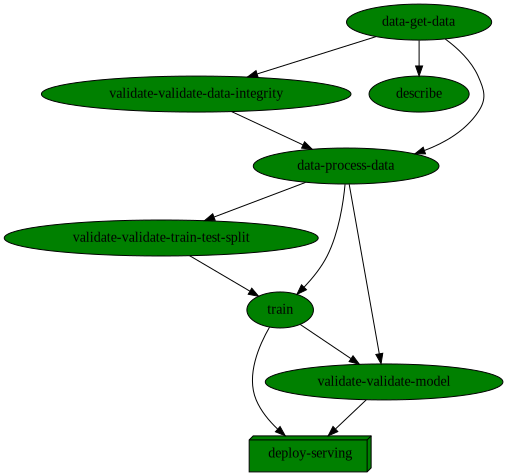

uid,start,state,name,parameters,results
...d545e6e4,Aug 11 22:31:57,completed,validate-validate-model,model_path=store://artifacts/liveops-demo/model:6ee0e3f0-1cbe-4bd0-800d-d23897e30150label_column=labelallow_validation_failure=True,passed_suite=False
...83201c82,Aug 11 22:31:14,completed,train,label_column=label,best_iteration=1accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=0.9999999999999999auc-macro=1.0auc-weighted=1.0
...d8b5ccd1,Aug 11 22:30:45,completed,validate-validate-train-test-split,label_column=labelallow_validation_failure=True,passed_suite=False
...c32eb385,Aug 11 22:30:19,completed,data-process-data,label_column=labeltest_size=0.1,
...1eab870a,Aug 11 22:29:53,completed,validate-validate-data-integrity,label_column=labelallow_validation_failure=True,passed_suite=False
...19b8c4c8,Aug 11 22:29:52,completed,describe,label_column=label,
...4d088202,Aug 11 22:29:26,completed,data-get-data,,


In [5]:
run_id = project.run(name="main", arguments={"allow_validation_failure" : True}, dirty=True, watch=True)

### Invoke Model

In [6]:
serving_fn = project.get_function("serving")
serving_fn.invoke('/v2/models/model/infer', {"inputs" : [[6.1, 2.8, 4.7, 1.2], [5.7, 3.8, 1.7, 0.3], [7.7, 2.6, 6.9, 2.3]]})

> 2023-08-11 22:34:06,653 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-liveops-demo-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': '6647f26d-2799-4bdc-a481-b2a572cb6815',
 'model_name': 'model',
 'outputs': [1, 0, 2]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [ ]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = "model"

# Get test set
df = project.get_artifact("train_test_set").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
iris_data = df.drop("label", axis=1).to_dict(orient="split")["data"]
iris_data[:5]

In [ ]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(iris_data)
    serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

### Simulate Drift Event

In [ ]:
import json
import v3io.dataplane

In [ ]:
v3io_client = v3io.dataplane.Client()

In [ ]:
drift_event = {'endpoint_id': '364ccdd1c2f6627ddfb523b16f53ae2b62e56ee8', 'drift_status': 'POSSIBLE_DRIFT', 'drift_measure': 0.87}

In [ ]:
v3io_client.stream.put_records(
    container='users',
    stream_path=f"pipelines/{project.name}/model-endpoints/log_stream",
    records=[{'data': json.dumps(drift_event), 'shard_id': 0}]
)